<h1 id="title">Predicting Motor Vehicle Accident Severity in Seattle, Washington by Oversampling Minority Classes to Achieve Balanced Training Data<\h1>

In [1]:
# Import packages and modules.
import io
import itertools
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import pylab as pl
import scipy
import scipy.optimize as opt
import seaborn as sns
import sklearn
import sys
import timeit
import warnings
from matplotlib.ticker import NullFormatter
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.sparse import csr_matrix
from sklearn import linear_model
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree
from sklearn import utils
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.exceptions import ConvergenceWarning
from timeit import default_timer
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")

In [3]:
# Define the starting time for this notebook. 
notebook_start_time = default_timer()

In [4]:
# This function computes the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def elapsed_time(start_time = notebook_start_time):
    return default_timer() - start_time   

In [5]:
# This function prints the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def print_elapsed_time(start_time = notebook_start_time):
    print("Elapsed time is", elapsed_time(start_time), "seconds.")
    return None

In [6]:
# Create a list of display options.
list_of_display_options_fully_qualified_names = str(\
"pd.options.display.chop_threshold, pd.options.display.float_format, pd.options.display.max_info_columns, pd.options.display.notebook_repr_html, \
pd.options.display.colheader_justify, pd.options.display.html, pd.options.display.max_info_rows, pd.options.display.pprint_nest_depth, \
pd.options.display.column_space, pd.options.display.large_repr, pd.options.display.max_rows, pd.options.display.precision, \
pd.options.display.date_dayfirst, pd.options.display.latex, pd.options.display.max_seq_items, pd.options.display.show_dimensions, \
pd.options.display.date_yearfirst, pd.options.display.max_categories, pd.options.display.memory_usage, pd.options.display.unicode, \
pd.options.display.encoding, pd.options.display.max_columns, pd.options.display.min_rows, pd.options.display.width, \
pd.options.display.expand_frame_repr, pd.options.display.max_colwidth, pd.options.display.multi_sparse").split(sep=', ')

# Initialize an empty list to store all the short names for display options.
list_of_display_options_short_names = list()
# For each fully qualified option name,
# get the option's short name and add it to the list of short names.
for fully_qualified_option_name in list_of_display_options_fully_qualified_names:
    # Get short option name.
    short_option_name = fully_qualified_option_name.split(sep='.')[-1]
    
    # Add short option name to list of display option short names.
    list_of_display_options_short_names.append(short_option_name)

# Define dictionary of display option settings.
dict_of_display_option_settings_short_names=\
{"max_info_columns": 1000,\
"colheader_justify": "right",\
"max_info_rows": 1000000,\
"column_space": 1000,\
"max_rows": 1000000,\
"precision": 9,\
"max_seq_items": 1000000000000,\
"show_dimensions": True,\
"max_categories": 100,\
"memory_usage": True,\
"max_columns": 1000,\
"max_colwidth": 1000,\
"float_format": lambda x: '%.9f' % x}

# Set pandas display options using dictionary of short names,
# and display the options/value pairs.
print("Setting display options...")
for key in list(dict_of_display_option_settings_short_names.keys()):
    # Set display option.
    pd.set_option(key, dict_of_display_option_settings_short_names[key])
    # Print display option name and value.
    print(key, ": ", pd.get_option(key), sep='')

Setting display options...
max_info_columns: 1000
colheader_justify: right
max_info_rows: 1000000
column_space: 1000
max_rows: 1000000
precision: 9
max_seq_items: 1000000000000
show_dimensions: True
max_categories: 100
memory_usage: True
max_columns: 1000
max_colwidth: 1000
float_format: <function <lambda> at 0x7f31c1a3c310>


In [7]:
# Set seed for random number generator.
# seed = np.int(os.times()[4]) # Use this line for better pseudo-random behavior.
seed = 42
print(seed)

42


In [8]:
# Attribute Information URL: https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf
# Read the Collisions Data CSV file and store it as a DataFrame.
# url="https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv" # HTTPError at 202009151050, using local copy of .csv instead.
# print(os.listdir("..")) # Print list of contents of current working directory.
local_path_to_csv = '~/IBM Data Science Professional Certificate Course/Course 9 - Applied Data Science Capstone/projects/Collisions.csv'
df=pd.read_csv(local_path_to_csv, low_memory=False)

In [9]:
# View the first few rows of the collisions DataFrame.
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.320757054,47.609407946,1,328476,329976,EA08706,Matched,Block,nan,BROADWAY BETWEEN E COLUMBIA ST AND BOYLSTON AVE,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020/01/22 00:00:00+00,1/22/2020 3:21:00 PM,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,N,Raining,Wet,Dark - Street Lights On,NaN,nan,NaN,11,From same direction - both going straight - both moving - sideswipe,0,0,N
1,-122.319560827,47.662220664,2,328142,329642,EA06882,Matched,Block,nan,8TH AVE NE BETWEEN NE 45TH E ST AND NE 47TH ST,,NaN,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2020/01/07 00:00:00+00,1/7/2020 8:00:00 AM,Mid-Block (not related to intersection),15.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE",NaN,N,Clear,Dry,Daylight,NaN,nan,NaN,32,One parked--one moving,0,0,Y
2,-122.327524508,47.604393273,3,20700,20700,1181833,Unmatched,Block,nan,JAMES ST BETWEEN 6TH AVE AND 7TH AVE,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/30 00:00:00+00,1/30/2004,Mid-Block (but intersection related),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,4030032.000000000,NaN,NaN,NaN,0,0,N
3,-122.327524934,47.708621579,4,332126,333626,M16001640,Unmatched,Block,nan,NE NORTHGATE WAY BETWEEN 1ST AVE NE AND NE NORTHGATE DR,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2016/01/23 00:00:00+00,1/23/2016,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N
4,-122.292120049,47.559009080,5,328238,329738,3857118,Unmatched,Block,nan,M L KING JR ER WAY S BETWEEN S ANGELINE ST AND S EDMUNDS ST,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2020/01/26 00:00:00+00,1/26/2020,Mid-Block (not related to intersection),28.000000000,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221389 entries, 0 to 221388
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                213918 non-null  float64
 1   Y                213918 non-null  float64
 2   OBJECTID         221389 non-null  int64  
 3   INCKEY           221389 non-null  int64  
 4   COLDETKEY        221389 non-null  int64  
 5   REPORTNO         221389 non-null  object 
 6   STATUS           221389 non-null  object 
 7   ADDRTYPE         217677 non-null  object 
 8   INTKEY           71884 non-null   float64
 9   LOCATION         216801 non-null  object 
 10  EXCEPTRSNCODE    100986 non-null  object 
 11  EXCEPTRSNDESC    11779 non-null   object 
 12  SEVERITYCODE     221388 non-null  object 
 13  SEVERITYDESC     221389 non-null  object 
 14  COLLISIONTYPE    195159 non-null  object 
 15  PERSONCOUNT      221389 non-null  int64  
 16  PEDCOUNT         221389 non-null  int6

In [11]:
print_elapsed_time(notebook_start_time)

Elapsed time is 9.451031798998883 seconds.


<h2 id="data_wrangling">Data Wrangling</h2>

Steps for working with missing data:
<ol>
    <li>Identify missing data.</li>
    <li>Deal with missing data.</li>
    <li>Correct data format.</li>
</ol>

<h3 id="identifying_missing_data">Identifying Missing Data</h3>

The metadata document that accompanied the data set indicates that certain columns have "sentinel" values
that indicate an unknown or missing value. Each of these missing values will first be converted into NaN.
Subsequently, the NaN values will be dropped from the DataFrame.

In [12]:
# If any row of the collisions DataFrame contains a sentinel value representing "unknown",
# then replace it with NaN. 
# Sentinels for "unknown" are listed in the metadata document that accompanies the dataset.
df_unknowns_converted_to_nan = df.replace(to_replace=\
{"EXCEPTRSNCODE": " ",\
 "EXCEPTRSNDESC": "Not Enough Information, or Insufficient Location Information",\
 "SEVERITYCODE": "0",\
 "SEVERITYDESC": "Unknown",\
 "JUNCTIONTYPE": "Unknown",\
 "WEATHER": "Unknown",\
 "ROADCOND": "Unknown",\
 "LIGHTCOND": "Unknown",\
 "SDOT_COLCODE": float(0),\
 "SDOT_COLDESC": "NOT ENOUGH INFORMATION / NOT APPLICABLE",\
 "ST_COLCODE": " ",\
 "ST_COLDESC": "Not stated"},\
value=np.nan, inplace=False, limit=None, regex=False, method='pad')

df_unknowns_converted_to_nan.replace(to_replace={"ST_COLCODE": "0", }, value=np.nan, inplace=True, limit=None, regex=False, method='pad')

In [13]:
print_elapsed_time(notebook_start_time)

Elapsed time is 16.296449372995994 seconds.


<h3 id="deal_with_missing_data">Deal with Missing Data</h3>

<ol>
    <li>Drop the Data
        <ol>
            <li>Drop entire row.</li>
            <li>Drop entire column.</li>
        </ol>
    </li>
    <li>Replace the Data
        <ol>
            <li>Replace data by mean.</li>
            <li>Replace data by frequency.</li>
            <li>Replace data based on other functions.</li>
        </ol>
    </li>
        
</ol>

Whole columns should be dropped only if most entries in the column are empty.

In [14]:
print(list(df.columns))

['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR']


In [15]:
# Drop any column from the collisions DataFrame if it satisfies at least one of the following conditions:
# 1) more than 15% of the column's data is NaN;
# 2) the column only contains unique identification keys, or information not useful for model building;
# 3) the column's data is categorical but does not fit into a small (< 15) number of categories;
# 4) information in the column is redundant because it is already represented by another column;
# 5) it is not clear how to interpret the column's data.
list_of_columns_to_drop = ["ADDRTYPE",\
                           "STATUS",\
                           "OBJECTID",\
                           "INCKEY",\
                           "COLDETKEY",\
                           "REPORTNO",\
                           "INTKEY",\
                           "LOCATION",\
                           "EXCEPTRSNCODE",\
                           "EXCEPTRSNDESC",\
                           "SEVERITYDESC",\
                           "PERSONCOUNT",\
                           "INCDATE",\
                           "INCDTTM",\
                           "JUNCTIONTYPE",\
                           "SDOT_COLCODE",\
                           "SDOT_COLDESC",\
                           "INATTENTIONIND",\
                           "UNDERINFL",\
                           "PEDROWNOTGRNT",\
                           "SDOTCOLNUM",\
                           "SPEEDING",\
                           "ST_COLCODE",\
                           "ST_COLDESC",\
                           "SEGLANEKEY",\
                           "CROSSWALKKEY",\
                           "HITPARKEDCAR"]

In [16]:
# Drop the selected columns from the DataFrame after converting unknowns to NaN.
# Store the result in a new DataFrame.
df_drop_columns = df_unknowns_converted_to_nan.drop(columns=list_of_columns_to_drop, inplace=False)

In [17]:
# Drop any row that contains at least one NaN.
df_drop_columns_and_rows = df_drop_columns.dropna(axis="index", how="any", thresh=None, subset=None, inplace=False)

In [18]:
minor_severity_labels = ['1', '2']
major_severity_labels = ['2b', '3']

In [19]:
series_is_severe = df_drop_columns_and_rows['SEVERITYCODE'].isin(major_severity_labels)

In [20]:
series_is_severe.value_counts()

False    168603
True       3269
Name: SEVERITYCODE, Length: 2, dtype: int64

In [21]:
# Define a new column called 'IS_SEVERE'.
# For each row of the DataFrame, if 'SEVERITYCODE' is '2b' or '3', then 'IS_SEVERE' gets the boolean value of True.
# If 'SEVERITYCODE' is '1' or '2', then 'IS_SEVERE' gets the boolean value of False.
df_drop_columns_and_rows.insert(0, 'IS_SEVERE', series_is_severe)

In [22]:
df_drop_columns_and_rows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   IS_SEVERE        171872 non-null  bool   
 1   X                171872 non-null  float64
 2   Y                171872 non-null  float64
 3   SEVERITYCODE     171872 non-null  object 
 4   COLLISIONTYPE    171872 non-null  object 
 5   PEDCOUNT         171872 non-null  int64  
 6   PEDCYLCOUNT      171872 non-null  int64  
 7   VEHCOUNT         171872 non-null  int64  
 8   INJURIES         171872 non-null  int64  
 9   SERIOUSINJURIES  171872 non-null  int64  
 10  FATALITIES       171872 non-null  int64  
 11  WEATHER          171872 non-null  object 
 12  ROADCOND         171872 non-null  object 
 13  LIGHTCOND        171872 non-null  object 
dtypes: bool(1), float64(2), int64(6), object(5)
memory usage: 18.5+ MB


In [23]:
df_drop_columns_and_rows.head()

,IS_SEVERE,X,Y,SEVERITYCODE,COLLISIONTYPE,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,WEATHER,ROADCOND,LIGHTCOND
0,False,-122.320757054,47.609407946,1,Sideswipe,0,0,2,0,0,0,Raining,Wet,Dark - Street Lights On
1,False,-122.319560827,47.662220664,1,Parked Car,0,0,2,0,0,0,Clear,Dry,Daylight
5,False,-122.374193726,47.564075600,1,Rear Ended,0,0,2,0,0,0,Clear,Dry,Daylight
6,False,-122.290734129,47.709276309,1,Other,0,0,1,0,0,0,Clear,Wet,Daylight
8,False,-122.336564829,47.590397830,1,Sideswipe,0,0,2,0,0,0,Overcast,Dry,Daylight


In [24]:
print_elapsed_time(notebook_start_time)

Elapsed time is 18.541612403998442 seconds.


<h3 id="correct_data_format">Correct Data Format</h3>

Ensure that each data type is appropriate for the corresponding feature.
Cast columns of type "object" as type "category", but leave all other column types unaltered.

In [25]:
# Create new DataFrame to store converted data types.
df_converted = pd.DataFrame()

for column in list(df_drop_columns_and_rows.columns):
    if (df_drop_columns_and_rows[column].dtype in [np.dtype('object')]):
        df_converted[column] = df_drop_columns_and_rows[column].astype('category')
    # Copy all other columns to new DataFrame without changing their types.
    else:
        df_converted[column] = df_drop_columns_and_rows[column]

In [26]:
# Create DataFrame of categorical or integer columns, inclusive.
df_categorical = df_converted.select_dtypes(include=['bool', 'category', 'integer'])

In [27]:
print_elapsed_time(notebook_start_time)

Elapsed time is 19.141967835996184 seconds.


<h2 id="feature_selection">Feature selection</h2>

#### Features before One-Hot Encoding

In [28]:
df_categorical.head()

,IS_SEVERE,SEVERITYCODE,COLLISIONTYPE,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,WEATHER,ROADCOND,LIGHTCOND
0,False,1,Sideswipe,0,0,2,0,0,0,Raining,Wet,Dark - Street Lights On
1,False,1,Parked Car,0,0,2,0,0,0,Clear,Dry,Daylight
5,False,1,Rear Ended,0,0,2,0,0,0,Clear,Dry,Daylight
6,False,1,Other,0,0,1,0,0,0,Clear,Wet,Daylight
8,False,1,Sideswipe,0,0,2,0,0,0,Overcast,Dry,Daylight


In [29]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   IS_SEVERE        171872 non-null  bool    
 1   SEVERITYCODE     171872 non-null  category
 2   COLLISIONTYPE    171872 non-null  category
 3   PEDCOUNT         171872 non-null  int64   
 4   PEDCYLCOUNT      171872 non-null  int64   
 5   VEHCOUNT         171872 non-null  int64   
 6   INJURIES         171872 non-null  int64   
 7   SERIOUSINJURIES  171872 non-null  int64   
 8   FATALITIES       171872 non-null  int64   
 9   WEATHER          171872 non-null  category
 10  ROADCOND         171872 non-null  category
 11  LIGHTCOND        171872 non-null  category
dtypes: bool(1), category(5), int64(6)
memory usage: 10.2 MB


In [30]:
print_elapsed_time(notebook_start_time)

Elapsed time is 19.549830735995783 seconds.


<h2 id="imbalanced_data">Dealing with Imbalanced Data</h2>

Because the data is imbalanced, we split the DataFrame into four DataFrames, one for each value of the SEVERITYCODE feature.

In [31]:
print('IS_SEVERE relative frequencies:')
print(df_categorical['IS_SEVERE'].value_counts(normalize=True, dropna=False))

IS_SEVERE relative frequencies:
False   0.980980032
True    0.019019968
Name: IS_SEVERE, Length: 2, dtype: float64


In [32]:
print("IS_SEVERE relative frequencies:")
print(df_categorical['IS_SEVERE'].value_counts(normalize=False, dropna=False))

IS_SEVERE relative frequencies:
False    168603
True       3269
Name: IS_SEVERE, Length: 2, dtype: int64


In [33]:
df_class_major_severity = df_categorical[df_categorical['IS_SEVERE']]
df_class_minor_severity = df_categorical[~df_categorical['IS_SEVERE']]

In [34]:
type(df_class_major_severity)

pandas.core.frame.DataFrame

In [35]:
df_class_major_severity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3269 entries, 116 to 221277
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   IS_SEVERE        3269 non-null   bool    
 1   SEVERITYCODE     3269 non-null   category
 2   COLLISIONTYPE    3269 non-null   category
 3   PEDCOUNT         3269 non-null   int64   
 4   PEDCYLCOUNT      3269 non-null   int64   
 5   VEHCOUNT         3269 non-null   int64   
 6   INJURIES         3269 non-null   int64   
 7   SERIOUSINJURIES  3269 non-null   int64   
 8   FATALITIES       3269 non-null   int64   
 9   WEATHER          3269 non-null   category
 10  ROADCOND         3269 non-null   category
 11  LIGHTCOND        3269 non-null   category
dtypes: bool(1), category(5), int64(6)
memory usage: 199.6 KB


In [36]:
type(df_class_minor_severity)

pandas.core.frame.DataFrame

In [37]:
df_class_minor_severity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168603 entries, 0 to 221388
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   IS_SEVERE        168603 non-null  bool    
 1   SEVERITYCODE     168603 non-null  category
 2   COLLISIONTYPE    168603 non-null  category
 3   PEDCOUNT         168603 non-null  int64   
 4   PEDCYLCOUNT      168603 non-null  int64   
 5   VEHCOUNT         168603 non-null  int64   
 6   INJURIES         168603 non-null  int64   
 7   SERIOUSINJURIES  168603 non-null  int64   
 8   FATALITIES       168603 non-null  int64   
 9   WEATHER          168603 non-null  category
 10  ROADCOND         168603 non-null  category
 11  LIGHTCOND        168603 non-null  category
dtypes: bool(1), category(5), int64(6)
memory usage: 10.0 MB


In [38]:
print("IS_SEVERE relative frequencies:")
print(df_class_major_severity["IS_SEVERE"].value_counts(normalize=False, dropna=False))

IS_SEVERE relative frequencies:
True    3269
Name: IS_SEVERE, Length: 1, dtype: int64


In [39]:
print("IS_SEVERE relative frequencies:")
print(df_class_minor_severity["IS_SEVERE"].value_counts(normalize=False, dropna=False))

IS_SEVERE relative frequencies:
False    168603
Name: IS_SEVERE, Length: 1, dtype: int64


In [40]:
# Store and print the size of the all classes.
class_major_severity_size = len(df_class_major_severity)
class_minor_severity_size = len(df_class_minor_severity)
print('class_major_severity_size =', class_major_severity_size)
print('class_minor_severity_size =', class_minor_severity_size)
print()
# Store and print the size of the minority class.
minority_class_size = len(df_class_major_severity)
print('minority_class_size =', minority_class_size)

class_major_severity_size = 3269
class_minor_severity_size = 168603

minority_class_size = 3269


In [41]:
print_elapsed_time(notebook_start_time)

Elapsed time is 20.91159389400127 seconds.


<h2 id='sample_size_class_3'>Sample all Classes Equally to Create a Balanced Training Set<\h2>

In [42]:
# Number of folds for cross-validation
number_of_folds = 4
print('number_of_folds = %f' % (number_of_folds))

number_of_folds = 4.000000


In [43]:
# This parameter determines what fraction of the data is reserved for testing.
# It must be between 0 and 1, exclusive, i.e. 0 < test_size_ratio < 1.
size_of_test_set = 100 # Number of samples in the test set.
test_size_ratio = size_of_test_set / len(df_categorical)
print('test_size_ratio = %f' % (test_size_ratio))

# Using train/test splits, set aside part of the data for testing.
df_class_minor_severity_train_pre_sampling, df_class_minor_severity_test =\
    train_test_split(df_class_minor_severity, test_size=test_size_ratio, random_state=seed)

df_class_major_severity_train_pre_sampling, df_class_major_severity_test =\
    train_test_split(df_class_major_severity, test_size=test_size_ratio, random_state=seed)

test_size_ratio = 0.000582


In [44]:
# Build a balanced training set by sampling the imbalanced training data equally by class:

# Set a sampling parameter to control the amount of oversampling for the minority class.
# Oversampling requires this parameter to be greater than 1.
# If this parameter is less than or equal to 1, then oversampling will not occur.
size_of_training_set = 100 # Number of samples in training set.
sampling_ratio = size_of_training_set / (2 * len(df_class_major_severity_train_pre_sampling))
print('size_of_training_set = %f' % (size_of_training_set))
print('sampling_ratio = %f' % (sampling_ratio))

# Set the replace parameter of the sample method based on the sampling ratio.
# If the sampling_ratio > 1, sample with replacement.
# Otherwise, sample without replacement.
sample_with_replacement = bool(sampling_ratio > 1)
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class major severity with replacement: %s' % (sample_with_replacement))

# Sample the minority class's training set based on the sampling parameter and store the sample for later concatenation.
df_class_major_severity_train = df_class_major_severity_train_pre_sampling.sample(frac=sampling_ratio, replace=sample_with_replacement, axis='index', random_state=seed)

# Store the size of the minority class's training set.
df_class_major_severity_train_size = df_class_major_severity_train.shape[0]

# Take a sample of the other class's pre-sampling training data,
# where the sample size taken is equal to the size of the minority class's training set.
# If the sample size to be taken exceeds the number of samples in available, sample with replacement.

# Sampling for class minor_severity
sample_with_replacement = bool(df_class_major_severity_train_size > df_class_minor_severity_train_pre_sampling.shape[0])
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class minor_severity with replacement: %s' % (sample_with_replacement))
df_class_minor_severity_train = df_class_minor_severity_train_pre_sampling.sample(n=df_class_major_severity_train_size,\
                                                                                   replace=sample_with_replacement, axis='index',\
                                                                                   random_state=seed)

sampling_ratio = 0.015305
Sample class major severity with replacement: False
Sample class minor_severity with replacement: False


In [45]:
# Make a balanced, unshuffled training set by concatenating the equal sized samples of the training sets for each class.
df_train_balanced_not_shuffled = pd.concat([df_class_minor_severity_train, df_class_major_severity_train], axis='index')

# Make a not necessarily balanced testing set by concatenating the testing sets for each class.
df_test_not_shuffled = pd.concat([df_class_minor_severity_test, df_class_major_severity_test], axis='index')

In [46]:
# Shuffle the training set and store it for tuning hyper-parameters and for cross-validation.
df_train = shuffle(df_train_balanced_not_shuffled, random_state=seed)

# Shuffle the unbalanced DataFrame and store it for validation and for comparing the models.
df_test = shuffle(df_test_not_shuffled, random_state=seed)

In [47]:
# Verify the training DataFrame is balanced.
print("IS_SEVERE relative frequencies:")
print(df_train["IS_SEVERE"].value_counts(normalize=False, dropna=False))

IS_SEVERE relative frequencies:
True     50
False    50
Name: IS_SEVERE, Length: 2, dtype: int64


In [48]:
# Verify the new DataFrame is balanced.
print("IS_SEVERE relative frequencies:")
print(df_train["IS_SEVERE"].value_counts(normalize=True, dropna=False))

IS_SEVERE relative frequencies:
True    0.500000000
False   0.500000000
Name: IS_SEVERE, Length: 2, dtype: float64


Let's define a feature set represented by the DataFrame X. 

In [49]:
X = df_train.drop(columns=['IS_SEVERE', 'SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)

In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 122166 to 76523
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   COLLISIONTYPE  100 non-null    category
 1   PEDCOUNT       100 non-null    int64   
 2   PEDCYLCOUNT    100 non-null    int64   
 3   VEHCOUNT       100 non-null    int64   
 4   WEATHER        100 non-null    category
 5   ROADCOND       100 non-null    category
 6   LIGHTCOND      100 non-null    category
dtypes: category(4), int64(3)
memory usage: 5.0 KB


We also define the data for the target variable, SEVERITYCODE, by the array y:

In [51]:
y = df_train['IS_SEVERE'].to_numpy()

In [52]:
print_elapsed_time(notebook_start_time)

Elapsed time is 22.611517981997167 seconds.


## Transform the Data 

We normalize the data by transforming it so that it is compatible
with the machine learning estimators we use in this notebook.
We use special care with sparse matrix data so as to not destroy the
structure.

In [53]:
# Create a OneHotEncoder and fit it to the features.
# The fit is performed on the data set before the any test/train splits.
# The data will be encoded as a sparse matrix, the default behavior.
start_time = default_timer()
print("Fitting OneHotEncoder to training data...")
encoder = OneHotEncoder(sparse=True, handle_unknown='error')
encoder.fit(df_categorical.drop(columns=['IS_SEVERE', 'SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False))
#encoder.fit(X)
X = encoder.transform(X)
print("Completed in", elapsed_time(start_time), "seconds.")
# Display the categories of the encoder.
print(encoder.get_feature_names())

Fitting OneHotEncoder to training data...
Completed in 0.2520520630059764 seconds.
['x0_Angles' 'x0_Cycles' 'x0_Head On' 'x0_Left Turn' 'x0_Other'
 'x0_Parked Car' 'x0_Pedestrian' 'x0_Rear Ended' 'x0_Right Turn'
 'x0_Sideswipe' 'x1_0' 'x1_1' 'x1_2' 'x1_3' 'x1_4' 'x1_5' 'x1_6' 'x2_0'
 'x2_1' 'x2_2' 'x3_0' 'x3_1' 'x3_2' 'x3_3' 'x3_4' 'x3_5' 'x3_6' 'x3_7'
 'x3_8' 'x3_9' 'x3_10' 'x3_11' 'x3_12' 'x3_13' 'x3_14' 'x3_15'
 'x4_Blowing Sand/Dirt' 'x4_Clear' 'x4_Fog/Smog/Smoke' 'x4_Other'
 'x4_Overcast' 'x4_Partly Cloudy' 'x4_Raining' 'x4_Severe Crosswind'
 'x4_Sleet/Hail/Freezing Rain' 'x4_Snowing' 'x5_Dry' 'x5_Ice' 'x5_Oil'
 'x5_Other' 'x5_Sand/Mud/Dirt' 'x5_Snow/Slush' 'x5_Standing Water'
 'x5_Wet' 'x6_Dark - No Street Lights' 'x6_Dark - Street Lights Off'
 'x6_Dark - Street Lights On' 'x6_Dark - Unknown Lighting' 'x6_Dawn'
 'x6_Daylight' 'x6_Dusk' 'x6_Other']


In [54]:
type(X)

scipy.sparse.csr.csr_matrix

In [55]:
X.shape

(100, 62)

In [56]:
y.shape

(100,)

In [57]:
print_elapsed_time(notebook_start_time)

Elapsed time is 23.388544709996495 seconds.


<h2 id="logistic_regression">Building a Logistic Regression Model<\h2>

In [58]:
t0 = default_timer()
logistic_regression_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LogisticRegression(solver='saga', multi_class='auto', penalty='l1', max_iter=10000, verbose=1000, n_jobs=-1, random_state=seed), verbose=True)
scoring = ['f1_macro', 'f1_weighted', 'neg_log_loss', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
logistic_regression_scores = cross_validate(logistic_regression_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("Logistic regression score keys:", sorted(logistic_regression_scores.keys()))
print('Logistic Regression classifiers constructed in %f seconds.' % elapsed_time(t0))

Logistic regression score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_neg_log_loss', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
Logistic Regression classifiers constructed in 3.782122 seconds.


In [59]:
print_elapsed_time(notebook_start_time)

Elapsed time is 27.420573647999845 seconds.


<h2 id="support_vector_machine">Building a Support Vector Machine<\h2>

In [60]:
t0 = default_timer()
linear_svc_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LinearSVC(penalty='l1', dual=False, random_state=seed, max_iter=100), verbose=True)
scoring = ['f1_macro', 'f1_weighted', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
linear_svc_scores = cross_validate(linear_svc_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("Support Vector Machine score keys:", sorted(linear_svc_scores.keys()))
print('Support Vector Machine classifiers constructed in %f seconds.' % elapsed_time(t0))

Support Vector Machine score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
Support Vector Machine classifiers constructed in 0.299323 seconds.


In [61]:
print_elapsed_time(notebook_start_time)

Elapsed time is 27.91203604099428 seconds.


<h2 id="knn_classifier">Building a k-Nearsest Neighbors Classifier<\h2>

In [62]:
t0 = default_timer()

# Set maximum number of neighbors based on number of samples and number of folds to prevent errors.
maximum_number_of_neighbors = min(199, np.int((X.shape[0] * (1 - 1 / number_of_folds))) - 1) # Take the smaller of the two parameters for min().
k_neighbors_pipeline = make_pipeline(\
    StandardScaler(with_mean=False),\
    KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=-1, p=1, weights='distance'), verbose=True)

# Use only odd numbers of neighbors to avoid ties.
# Number of neighbors range starts high and ends low, allowing user to  monitor kernel messages for possible local maxima in score.
grid_parameters = {'kneighborsclassifier__n_neighbors': range(maximum_number_of_neighbors, 3, -2)}
scoring = ['recall_weighted']
grid_search_cv = GridSearchCV(k_neighbors_pipeline, param_grid=grid_parameters,\
                              scoring=scoring, \
                              n_jobs=-1, refit='recall_weighted', cv=number_of_folds, verbose=200, pre_dispatch=2**10, error_score='raise',\
                              return_train_score=False)

grid_search_cv.fit(X, y)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   2 out of 144 | elapsed:    2.8s remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   3 out of 144 | elapsed:    2.9s remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   4 out of 144 | elapsed:    2.9s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of 144 | elapsed:    3.0s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   6 out of 144 | elapsed:    3.1s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   7 out of 144 | elapsed:    3.1s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   8 out of 144 | elapsed:    3.1s remaining:   53.3s
[Parallel(n_jobs=-1)]: Done   9 out of 144 | elapsed:    3.2s remaining:   48.0s
[Parallel(n_jobs=-1)]: Done  10 out of 144 | elapsed:    3.2s remaining:   43.0s
[Parallel(n_jobs=-1)]: Done  11 out of 144 | elapsed:    3.3s remaining

GridSearchCV(cv=4, error_score='raise',
             estimator=Pipeline(steps=[('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_jobs=-1, p=1,
                                                             weights='distance'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': range(74, 3, -2)},
             pre_dispatch=1024, refit='recall_weighted',
             scoring=['recall_weighted'], verbose=200)

In [63]:
print('Completed grid search in %f seconds' % (elapsed_time(t0)))

Completed grid search in 8.186600 seconds


In [64]:
# Store best KNeighborsClassifier from GridSearchCV and print its parameters.
k_neighbors_clf = grid_search_cv.best_estimator_
print('Best KNeighborsClassifier parameters:')
for key in k_neighbors_clf.get_params().keys():
    print(key, ':', k_neighbors_clf.get_params()[key])

Best KNeighborsClassifier parameters:
memory : None
steps : [('standardscaler', StandardScaler(with_mean=False)), ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=48, p=1, weights='distance'))]
verbose : True
standardscaler : StandardScaler(with_mean=False)
kneighborsclassifier : KNeighborsClassifier(n_jobs=-1, n_neighbors=48, p=1, weights='distance')
standardscaler__copy : True
standardscaler__with_mean : False
standardscaler__with_std : True
kneighborsclassifier__algorithm : auto
kneighborsclassifier__leaf_size : 30
kneighborsclassifier__metric : minkowski
kneighborsclassifier__metric_params : None
kneighborsclassifier__n_jobs : -1
kneighborsclassifier__n_neighbors : 48
kneighborsclassifier__p : 1
kneighborsclassifier__weights : distance


In [65]:
t0 = default_timer()
scoring = ['f1_macro', 'f1_weighted', 'neg_log_loss', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
k_neighbors_scores = cross_validate(k_neighbors_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("k-Neighbors score keys:", sorted(k_neighbors_scores.keys()))
print('k-Neighbors Classifiers constructed in %f seconds.' % elapsed_time(t0))

k-Neighbors score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_neg_log_loss', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
k-Neighbors Classifiers constructed in 3.772972 seconds.


In [66]:
print_elapsed_time(notebook_start_time)

Elapsed time is 40.32448424399627 seconds.


## Test the Models and Compare their Performance

In [67]:
#df_categorical.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 65554 to 58457
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   IS_SEVERE        101 non-null    bool    
 1   SEVERITYCODE     101 non-null    category
 2   COLLISIONTYPE    101 non-null    category
 3   PEDCOUNT         101 non-null    int64   
 4   PEDCYLCOUNT      101 non-null    int64   
 5   VEHCOUNT         101 non-null    int64   
 6   INJURIES         101 non-null    int64   
 7   SERIOUSINJURIES  101 non-null    int64   
 8   FATALITIES       101 non-null    int64   
 9   WEATHER          101 non-null    category
 10  ROADCOND         101 non-null    category
 11  LIGHTCOND        101 non-null    category
dtypes: bool(1), category(5), int64(6)
memory usage: 7.8 KB


In [68]:
# Print the relative frequencies for the validation DataFrame.
print("IS_SEVERE relative frequencies:")
print(df_test['IS_SEVERE'].value_counts(normalize=False, dropna=False))

IS_SEVERE relative frequencies:
False    99
True      2
Name: IS_SEVERE, Length: 2, dtype: int64


In [69]:
# Print the relative frequencies for the validation DataFrame.
print("IS_SEVERE relative frequencies:")
print(df_test['IS_SEVERE'].value_counts(normalize=True, dropna=False))

IS_SEVERE relative frequencies:
False   0.980198020
True    0.019801980
Name: IS_SEVERE, Length: 2, dtype: float64


In [70]:
# Encode the data using the OneHotEncoder fitted before the train/test split.
start_time = default_timer()
print('Transforming features using OneHotEncoder...')
X_test = df_test.drop(columns=['IS_SEVERE', 'SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)
X_test = encoder.transform(X_test)
print("Encoding completed in", elapsed_time(start_time), "seconds.")

Transforming features using OneHotEncoder...
Encoding completed in 0.023903230001451448 seconds.


In [71]:
y_test = df_test['IS_SEVERE'].to_numpy()

In [72]:
X_test.shape

(101, 62)

In [73]:
y_test.shape

(101,)

In [74]:
print_elapsed_time(notebook_start_time)

Elapsed time is 41.30073261399957 seconds.


In [75]:
# Set starting time for reports and graphics.
t0 = default_timer()

In [76]:
# Report statistics of the models built for each fold of the cross-validation.
print('Logistic Regression Cross-validation Scores:')
print()
for key in sorted(logistic_regression_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(logistic_regression_scores[key]), np.std(logistic_regression_scores[key])), sep='')
        print('%s :%s' % (key, logistic_regression_scores[key]), sep='')
        print()

Logistic Regression Cross-validation Scores:

fit_time: mean = 0.241694, std = 0.085074
fit_time :[0.21658921 0.17645288 0.38682365 0.18690991]

score_time: mean = 0.063951, std = 0.018302
score_time :[0.06016326 0.06532288 0.03946185 0.09085536]

test_f1_macro: mean = 0.704803, std = 0.111953
test_f1_macro :[0.71819646 0.63768116 0.58333333 0.88      ]

test_f1_weighted: mean = 0.704034, std = 0.112666
test_f1_weighted :[0.71729469 0.63884058 0.58       0.88      ]

test_neg_log_loss: mean = -0.640896, std = 0.162264
test_neg_log_loss :[-0.80184246 -0.58700042 -0.77549412 -0.39924887]

test_precision_macro: mean = 0.722319, std = 0.099888
test_precision_macro :[0.73333333 0.63961039 0.63492063 0.88141026]

test_precision_weighted: mean = 0.724164, std = 0.099809
test_precision_weighted :[0.736      0.63974026 0.63809524 0.88282051]

test_recall_macro: mean = 0.713141, std = 0.106024
test_recall_macro :[0.72435897 0.63782051 0.60897436 0.88141026]

test_recall_weighted: mean = 0.710000

Logistic Regression Model 1 of 4:

              precision    recall  f1-score   support

       Major   0.044444  1.000000  0.085106         2
       Minor   1.000000  0.565657  0.722581        99

    accuracy                       0.574257       101
   macro avg   0.522222  0.782828  0.403844       101
weighted avg   0.981078  0.574257  0.709957       101



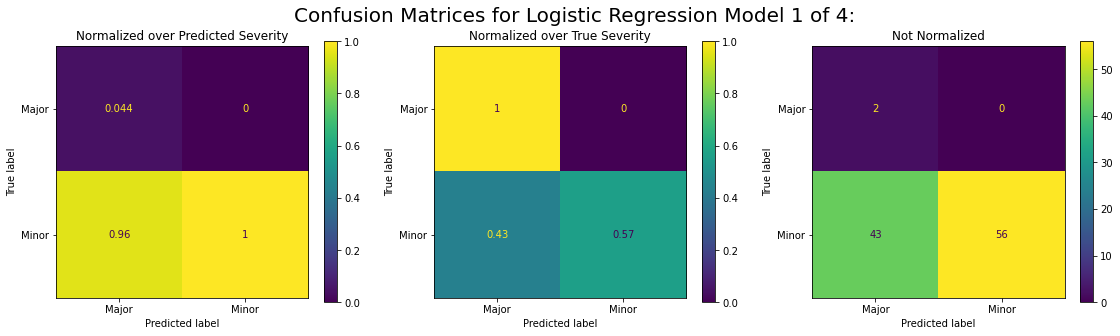

Logistic Regression Model 2 of 4:

              precision    recall  f1-score   support

       Major   0.043478  1.000000  0.083333         2
       Minor   1.000000  0.555556  0.714286        99

    accuracy                       0.564356       101
   macro avg   0.521739  0.777778  0.398810       101
weighted avg   0.981059  0.564356  0.701792       101



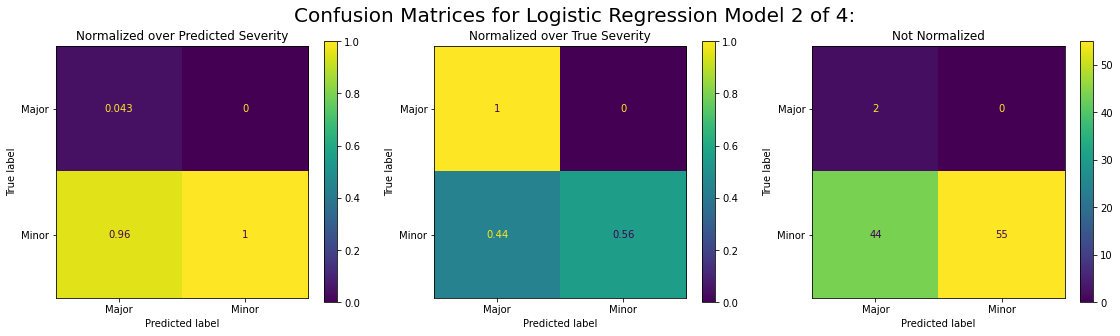

Logistic Regression Model 3 of 4:

              precision    recall  f1-score   support

       Major   0.048780  1.000000  0.093023         2
       Minor   1.000000  0.606061  0.754717        99

    accuracy                       0.613861       101
   macro avg   0.524390  0.803030  0.423870       101
weighted avg   0.981164  0.613861  0.741614       101



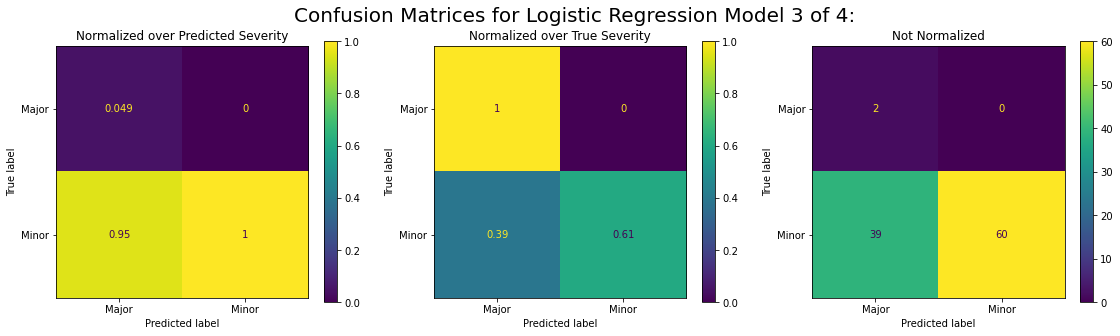

Logistic Regression Model 4 of 4:

              precision    recall  f1-score   support

       Major   0.050000  1.000000  0.095238         2
       Minor   1.000000  0.616162  0.762500        99

    accuracy                       0.623762       101
   macro avg   0.525000  0.808081  0.428869       101
weighted avg   0.981188  0.623762  0.749287       101



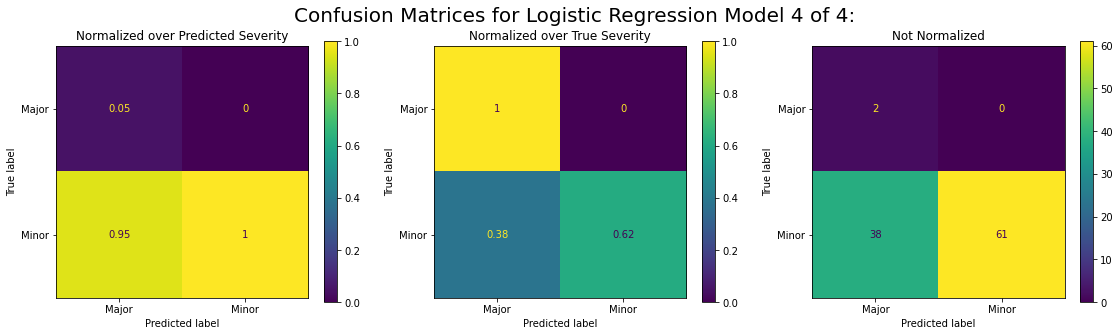

In [77]:
# For each logistic regression classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(logistic_regression_scores['estimator'])
#labels = ['1', '2', '2b', '3']
labels = [True, False]
target_names = ['Major', 'Minor']
display_labels = target_names
for index, logistic_regression_clf in zip(range(len(logistic_regression_scores['estimator'])), logistic_regression_scores['estimator']):
    y_test_predicted = logistic_regression_clf.predict(X_test)
    print('Logistic Regression Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=target_names, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Logistic Regression Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Severity", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=display_labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Severity", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=display_labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=display_labels, normalize=None, ax=ax)

    plt.show()

In [78]:
print_elapsed_time(notebook_start_time)

Elapsed time is 53.27348333699774 seconds.


In [79]:
# Report statistics of the models built for each fold of the cross-validation.
print('Support Vector Machine Cross-validation Scores:')
print()
for key in sorted(linear_svc_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(linear_svc_scores[key]), np.std(linear_svc_scores[key])), sep='')
        print('%s :%s' % (key, linear_svc_scores[key]), sep='')
        print()

Support Vector Machine Cross-validation Scores:

fit_time: mean = 0.043291, std = 0.020055
fit_time :[0.06679416 0.054456   0.01309514 0.0388186 ]

score_time: mean = 0.056909, std = 0.026329
score_time :[0.10240245 0.03924394 0.04158974 0.04440141]

test_f1_macro: mean = 0.687864, std = 0.100749
test_f1_macro :[0.71819646 0.59935897 0.59415584 0.83974359]

test_f1_weighted: mean = 0.687376, std = 0.101095
test_f1_weighted :[0.71729469 0.6        0.59220779 0.84      ]

test_precision_macro: mean = 0.696755, std = 0.097496
test_precision_macro :[0.73333333 0.59935897 0.61458333 0.83974359]

test_precision_weighted: mean = 0.698167, std = 0.097246
test_precision_weighted :[0.736      0.6        0.61666667 0.84      ]

test_recall_macro: mean = 0.692308, std = 0.098607
test_recall_macro :[0.72435897 0.59935897 0.60576923 0.83974359]

test_recall_weighted: mean = 0.690000, std = 0.099499
test_recall_weighted :[0.72 0.6  0.6  0.84]



Support Vector Machine Model 1 of 4:

              precision    recall  f1-score   support

       Major   0.048780  1.000000  0.093023         2
       Minor   1.000000  0.606061  0.754717        99

    accuracy                       0.613861       101
   macro avg   0.524390  0.803030  0.423870       101
weighted avg   0.981164  0.613861  0.741614       101



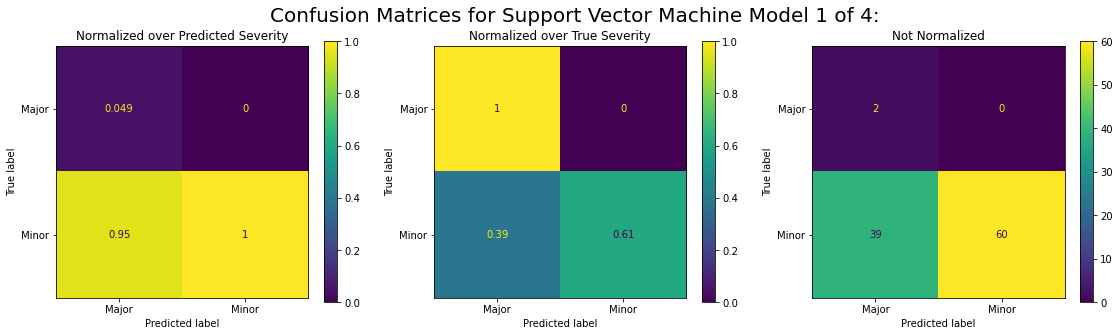

Support Vector Machine Model 2 of 4:

              precision    recall  f1-score   support

       Major   0.046512  1.000000  0.088889         2
       Minor   1.000000  0.585859  0.738854        99

    accuracy                       0.594059       101
   macro avg   0.523256  0.792929  0.413871       101
weighted avg   0.981119  0.594059  0.725983       101



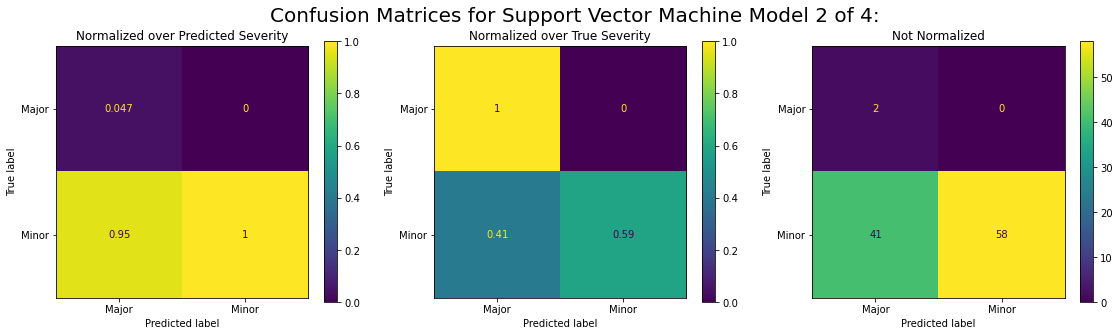

Support Vector Machine Model 3 of 4:

              precision    recall  f1-score   support

       Major   0.047619  1.000000  0.090909         2
       Minor   1.000000  0.595960  0.746835        99

    accuracy                       0.603960       101
   macro avg   0.523810  0.797980  0.418872       101
weighted avg   0.981141  0.603960  0.733847       101



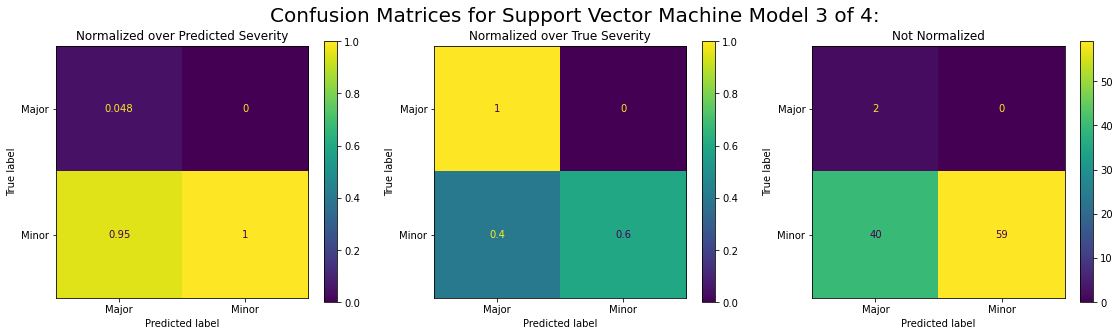

Support Vector Machine Model 4 of 4:

              precision    recall  f1-score   support

       Major   0.055556  1.000000  0.105263         2
       Minor   1.000000  0.656566  0.792683        99

    accuracy                       0.663366       101
   macro avg   0.527778  0.828283  0.448973       101
weighted avg   0.981298  0.663366  0.779071       101



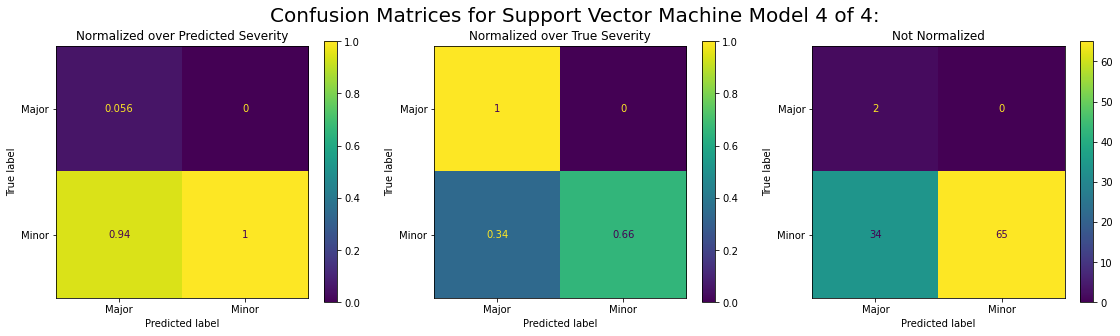

In [80]:
# For each support vector machine classifier in the cross-validation, print the score report and confusion matrices.
number_of_models = len(linear_svc_scores['estimator'])
#labels = ['1', '2', '2b', '3']
labels = [True, False]
target_names = ['Major', 'Minor']
display_labels = target_names
for index, linear_svc_clf in zip(range(len(linear_svc_scores['estimator'])), linear_svc_scores['estimator']):
    y_test_predicted = linear_svc_clf.predict(X_test)
    print('Support Vector Machine Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=target_names, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Support Vector Machine Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1,3,1)
    ax.set_title("Normalized over Predicted Severity", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=display_labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1,3,2)
    ax.set_title("Normalized over True Severity", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=display_labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1,3,3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=display_labels, normalize=None, ax=ax)
    
    plt.show()

In [81]:
print_elapsed_time(notebook_start_time)

Elapsed time is 63.2677365099953 seconds.


In [82]:
# Report statistics of the models built for each fold of the cross-validation.
print('k-Nearest Neighbors Cross-validation Scores:')
print()
for key in sorted(k_neighbors_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(k_neighbors_scores[key]), np.std(k_neighbors_scores[key])), sep='')
        print('%s :%s' % (key, k_neighbors_scores[key]), sep='')
        print()

k-Nearest Neighbors Cross-validation Scores:

fit_time: mean = 0.019570, std = 0.006236
fit_time :[0.0122993  0.01949382 0.01709056 0.0293963 ]

score_time: mean = 0.135948, std = 0.023274
score_time :[0.10235262 0.1392796  0.16794729 0.13421249]

test_f1_macro: mean = 0.698512, std = 0.059250
test_f1_macro :[0.71819646 0.59935897 0.72       0.75649351]

test_f1_weighted: mean = 0.698419, std = 0.059733
test_f1_weighted :[0.71729469 0.59871795 0.72       0.75766234]

test_neg_log_loss: mean = -4.530846, std = 1.725186
test_neg_log_loss :[-3.16123324 -7.34556524 -4.53712953 -3.07945407]

test_precision_macro: mean = 0.706262, std = 0.061405
test_precision_macro :[0.73333333 0.6038961  0.72115385 0.76666667]

test_precision_weighted: mean = 0.707209, std = 0.060914
test_precision_weighted :[0.736      0.60519481 0.72230769 0.76533333]

test_recall_macro: mean = 0.701122, std = 0.058548
test_recall_macro :[0.72435897 0.6025641  0.72115385 0.75641026]

test_recall_weighted: mean = 0.700000

k-Nearest Neighbor Model 1 of 4:

              precision    recall  f1-score   support

       Major   0.074074  1.000000  0.137931         2
       Minor   1.000000  0.747475  0.855491        99

    accuracy                       0.752475       101
   macro avg   0.537037  0.873737  0.496711       101
weighted avg   0.981665  0.752475  0.841282       101



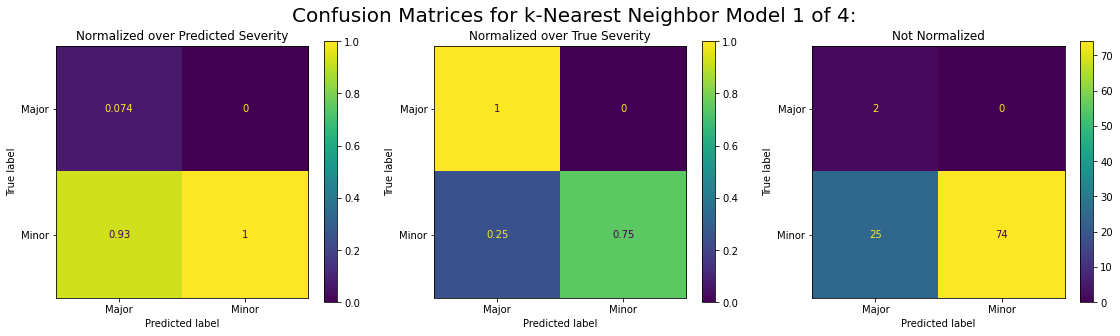

k-Nearest Neighbor Model 2 of 4:

              precision    recall  f1-score   support

       Major   0.074074  1.000000  0.137931         2
       Minor   1.000000  0.747475  0.855491        99

    accuracy                       0.752475       101
   macro avg   0.537037  0.873737  0.496711       101
weighted avg   0.981665  0.752475  0.841282       101



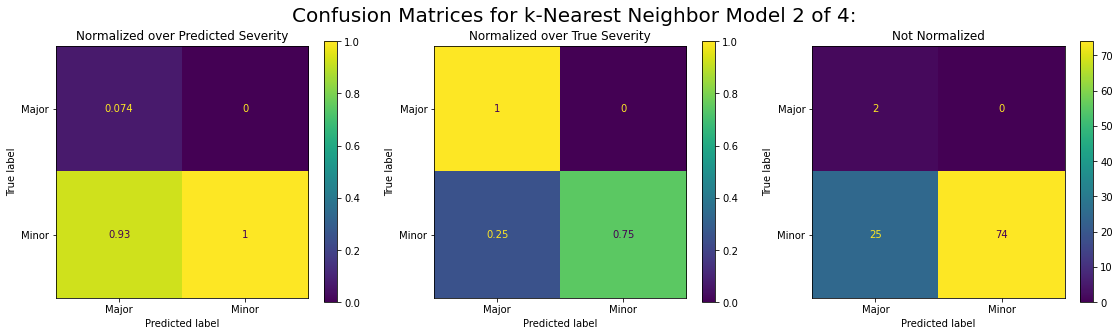

k-Nearest Neighbor Model 3 of 4:

              precision    recall  f1-score   support

       Major   0.076923  1.000000  0.142857         2
       Minor   1.000000  0.757576  0.862069        99

    accuracy                       0.762376       101
   macro avg   0.538462  0.878788  0.502463       101
weighted avg   0.981721  0.762376  0.847827       101



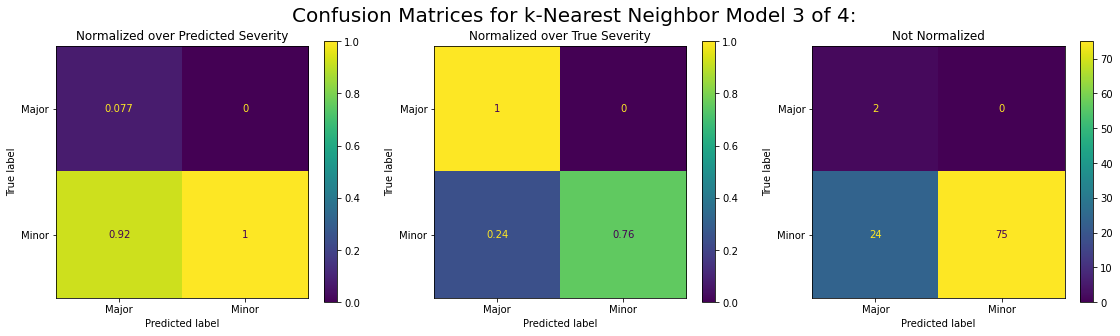

k-Nearest Neighbor Model 4 of 4:

              precision    recall  f1-score   support

       Major   0.083333  1.000000  0.153846         2
       Minor   1.000000  0.777778  0.875000        99

    accuracy                       0.782178       101
   macro avg   0.541667  0.888889  0.514423       101
weighted avg   0.981848  0.782178  0.860720       101



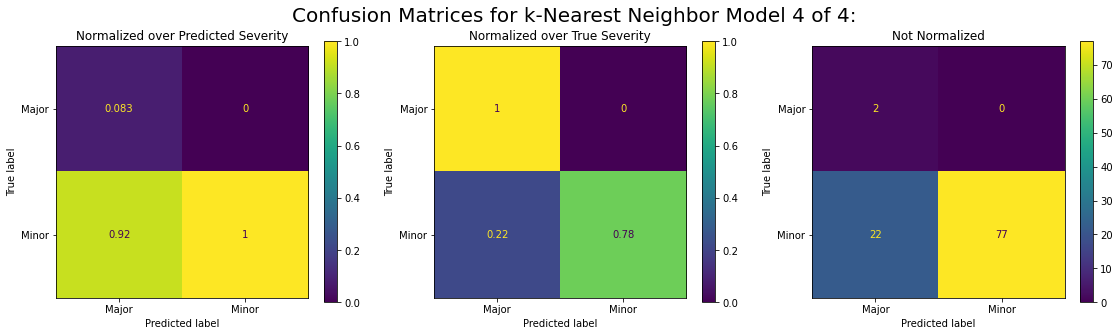

In [83]:
# For each k-Nearest Neighbor classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(k_neighbors_scores['estimator'])
#labels = ['1', '2', '2b', '3']
labels = [True, False]
target_names = ['Major', 'Minor']
display_labels = target_names
for index, knn_clf in zip(range(len(k_neighbors_scores['estimator'])), k_neighbors_scores['estimator']):
    y_test_predicted = knn_clf.predict(X_test)
    print('k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=target_names, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Severity", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=display_labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Severity", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=display_labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=display_labels, normalize=None, ax=ax)

    plt.show()

In [84]:
print('All reports and graphics generated in %f seconds.' % (elapsed_time(t0)))

All reports and graphics generated in 36.043942 seconds.


In [85]:
print_elapsed_time(notebook_start_time)

Elapsed time is 77.5987008230004 seconds.
